In [ ]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    num_samples=20,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

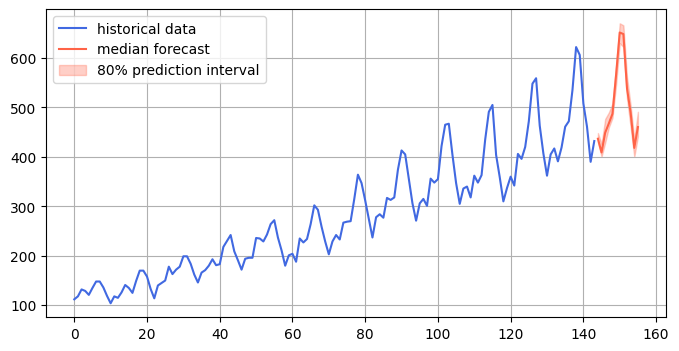

In [ ]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(df), len(df) + 12)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

**Konversi format data (.csv -> .arrow)**

In [2]:
from pathlib import Path
from typing import List, Union

import numpy as np
import pandas as pd
from gluonts.dataset.arrow import ArrowWriter

def convert_to_arrow(csv_path: str):
    """
    Store a given set of series into Arrow format at the specified path.

    Input data can be a CSV file with a 'close' column.
    """
    # Baca file CSV
    data = pd.read_csv(csv_path, parse_dates=['timestamp'])

    # Hitung jumlah total baris
    total_rows = len(data)

    # Hitung 70% dari total baris
    rows_to_take = int(0.7 * total_rows)

    # Ambil 70% pertama dari data
    data = data.head(rows_to_take)

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values(by='timestamp')

    # Ambil array dari kolom 'close'
    time_series = data['close'].to_numpy()

    # Set an arbitrary start time
    start = np.datetime64(data['timestamp'].iloc[0], "s")

    # Buat dataset yang terdiri dari satu seri waktu dengan satu start time
    dataset = {
        "start": start, 
        "target": time_series
    }

    return dataset

if __name__ == "__main__":
    # 42 LQ45
    dataset_name=["ACES","AMRT","ASII","BBRI","BRIS","CPIN","GGRM","ICBP",
                  "INKP","ITMG","MDKA","PGAS","SMGR","TOWR","ADRO","ANTM",
                  "BBCA","BBTN","BRPT","ESSA","GOTO","INCO","INTP","KLBF",
                  "MEDC","PTBA","SRTG","UNTR","AKRA","ARTO","BBNI","BMRI",
                  "BUKA","EXCL","HRUM","INDF","ISAT","MAPI","MTEL","SIDO",
                  "TLKM","UNVR"]

    dataset =[]

    count=0
    for ds in dataset_name:
        # Sesuaikan path ke lokasi file CSV dan output yang diinginkan


        data = pd.read_csv(f"/home/yogi/chronos-research/dataset/daily-all/{ds}.csv", parse_dates=['timestamp'])

        # Hitung jumlah total baris
        total_rows = len(data)

        count+=1

        dataset.append(convert_to_arrow(f"/home/yogi/chronos-research/dataset/daily-all/{ds}.csv"))

    print(count)

    # Tulis dataset ke file dengan format arrow menggunakan ArrowWriter
    ArrowWriter(compression="lz4").write_to_file(dataset, path="/home/yogi/chronos-research/arrow_data/test_lq45.arrow")

42


In [3]:
import pyarrow as pa

def read_arrow_file(file_path):
    with pa.OSFile(file_path, 'rb') as f:
        reader = pa.ipc.open_file(f)
        table = reader.read_all()
    print(table.to_pandas())

if __name__ == "__main__":
    read_arrow_file("/home/yogi/chronos-research/arrow_data/test_lq45.arrow")

        start                                             target
0  2007-11-06  [98, 101, 99, 95, 90, 86, 85, 87, 85, 84, 87, ...
1  2009-01-15  [39, 40, 40, 39, 39, 39, 37, 37, 38, 40, 39, 4...
2  2001-04-16  [98, 96, 98, 96, 88, 88, 90, 98, 98, 100, 108,...
3  2003-11-10  [97, 100, 105, 105, 105, 100, 97, 100, 102, 10...
4  2018-05-09  [545, 545, 620, 600, 600, 600, 585, 570, 555, ...
5  2001-04-16  [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 3...
6  2001-04-16  [12100, 12100, 12100, 12100, 12100, 12100, 121...
7  2010-10-07  [2975, 2850, 2725, 2775, 2800, 2775, 2725, 272...
8  2001-04-16  [230, 235, 220, 200, 215, 230, 245, 240, 240, ...
9  2007-12-18  [19600, 19000, 19000, 19000, 19000, 19000, 185...
10 2015-06-19  [435, 422, 401, 391, 384, 384, 383, 383, 383, ...
11 2003-12-15  [310, 300, 300, 305, 310, 305, 305, 305, 305, ...
12 2001-04-16  [1750, 1750, 1750, 1750, 1750, 1750, 1750, 175...
13 2010-03-08  [31, 39, 49, 61, 50, 46, 46, 44, 41, 41, 51, 5...
14 2008-07-16  [1730, 170

**Tokenisasi (Mean Scaling & Kuantisasi):**

In [5]:
from chronos import ChronosConfig, MeanScaleUniformBins
import pandas as pd
import torch
import numpy as np

n_numerical_tokens= 510
n_special_tokens = 2

# Load dataset
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/ANTM.csv')

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df = df.iloc[1165:1177]

print("timestamp= ",df['timestamp'].values)

# Extract 'close' column as the target (context)
context_data = df['close'].values
# context_data[3] = np.nan


context_tensor = torch.tensor(context_data).unsqueeze(0)  # Add batch dimension

n_tokens = n_numerical_tokens + n_special_tokens

print("n_tokens",n_tokens)

config = ChronosConfig(
    tokenizer_class="MeanScaleUniformBins",
    tokenizer_kwargs=dict(low_limit=-1.0, high_limit=1.0),
    n_tokens=n_tokens,
    n_special_tokens=n_special_tokens,
    pad_token_id=0,
    eos_token_id=1,
    use_eos_token=True,
    model_type="seq2seq",
    context_length=512,
    prediction_length=64,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
)

tokenizer = config.create_tokenizer()
assert isinstance(tokenizer, MeanScaleUniformBins)

context = context_tensor  # add batch dimension
# scale = torch.ones((1,))  # fix the scale to one to turn off scaling
print("context= ",context)

token_ids, _, scale = tokenizer._input_transform(context)

print("token_ids= ",token_ids)

# samples = tokenizer.output_transform(
#     token_ids.unsqueeze(1),  # add sample dimension
#     scale=scale,
# )

# print("samples= ",samples)

timestamp=  ['2005-10-03T00:00:00.000000000' '2005-10-04T00:00:00.000000000'
 '2005-10-05T00:00:00.000000000' '2005-10-06T00:00:00.000000000'
 '2005-10-07T00:00:00.000000000' '2005-10-10T00:00:00.000000000'
 '2005-10-11T00:00:00.000000000' '2005-10-12T00:00:00.000000000'
 '2005-10-13T00:00:00.000000000' '2005-10-14T00:00:00.000000000'
 '2005-10-17T00:00:00.000000000' '2005-10-18T00:00:00.000000000']
n_tokens 512
context=  tensor([[470, 474, 482, 466, 470, 466, 466, 470, 474, 474, 474, 470]])
Hasil mean scaling= tensor([[0.9972, 1.0057, 1.0226, 0.9887, 0.9972, 0.9887, 0.9887, 0.9972, 1.0057,
         1.0057, 1.0057, 0.9972]])
token_ids=  tensor([[510, 511, 511, 508, 510, 508, 508, 510, 511, 511, 511, 510]])


**Visualisasi hasil prediksi:**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import json
import torch
import random
import transformers
from statsmodels.tsa.seasonal import seasonal_decompose
from chronos import ChronosPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from gluonts.dataset.common import ListDataset
from tqdm.auto import tqdm


class ChronosForecaster:

    def __init__(self) -> None:
        transformers.set_seed(42)
        self.limit_pred_len = True
        pass

    @staticmethod
    def is_gpu():
        return torch.cuda.is_available()

    def get_series_decomposition(self, series, model='additive', period=12):
        result = seasonal_decompose(series, model=model, period=period)
        result.plot()
        return result

    def calculate_metrics(self, predicted, ground_truth):
        mae = mean_absolute_error(ground_truth, predicted)
        mse = mean_squared_error(ground_truth, predicted)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(ground_truth, predicted)
        r_squared = r2_score(ground_truth, predicted)

        return {
            'MAE': round(mae,2),
            'MSE': round(mse,2),
            'RMSE': round(rmse,2),
            'MAPE': round(mape,2),
            'R-squared': round(r_squared,2),
        }

    # Split by percentage
    def split_train_test(self, df, test_size=0.2, limit_pred_length=True):
        self.df = df
        _, _, self.y_train, self.y_test = train_test_split(df, df, test_size=test_size, random_state=42, shuffle=False)
        clipped = False
        self.limit_pred_len = limit_pred_length
        if len(self.y_test) > 64 and self.limit_pred_len:
            print(f"[!] Test array size is {len(self.y_test)} which is > 64!")
            print("Clipping test data size to first 64 samples for acceptable accuracy")
            self.y_test = self.y_test[:64]
            self.y_train = self.y_train[:-len(self.y_test)]
            clipped = True
        else:
            print('[!] WARNING: limit_pred_length is disabled! Far future prediction will have low accuracy!')
        return self.y_train, self.y_test, clipped

    # Split by number of samples to be predicted
    def split_train_test_by_sample_size(self, df, target_column, test_sample_size=24):
        self.df = df
        self.y_test:pd.DataFrame = df.iloc[-test_sample_size:][target_column]
        self.y_train:pd.DataFrame = df.iloc[:len(df)-test_sample_size][target_column]
        self.limit_pred_len = False
        return self.y_train, self.y_test

    def predict(self, model_name="amazon/chronos-t5-small", num_samples=20, temp=1, top_k=50, top_p=1, debug=True):
        device = "cpu"
        self.pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16
        )
        try:
            context = torch.tensor(self.y_train)
        except ValueError:
            context = torch.tensor(self.y_train.astype(float).values)
        prediction_length = len(self.y_test)
        if debug:
            print(f"Using {device}\nContext length = {len(self.y_train)}\nForecast length = {prediction_length}\nSample size = {num_samples}")
        self.forecast = self.pipeline.predict(
            context,
            prediction_length,
            num_samples=num_samples,
            temperature=temp,
            top_k=int(top_k),
            top_p=top_p,
            limit_prediction_length=self.limit_pred_len
        )

        # self.forecast_index = range(len(self.y_train), len(self.y_train) + prediction_length)
        self.forecast_index = range(self.y_test.index[0], self.y_test.index[-1] + 1)
        self.low, self.median, self.high = np.quantile(self.forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
        # self.median = self.forecast[0].numpy().mean(axis=0)           # Mean instead of median
        self.metrics = self.calculate_metrics(self.median, self.y_test)
        self.params = json.dumps({
                "model": model_name,
                "top_p": top_p,
                "top_k": top_k,
                "tempearature": temp,
                "num_samples": num_samples,
                "context_length": len(self.y_train),
                "prediction_length": prediction_length
            },
            indent=2)

        return (self.forecast, self.metrics, self.median)

    def plot_forecast(self, series:pd.Series):
        plt.figure(figsize=(8, 4))
        plt.plot(series, color="royalblue", label="Historical Data")
        plt.plot(self.y_test, color="green", label="Ground Truth")
        plt.plot(self.forecast_index, self.median, color="tomato", label="Median Forecast")
        plt.fill_between(self.forecast_index, self.low, self.high, color="tomato", alpha=0.3, label="80% Prediction Interval")
        plt.title('CHRONOS Forecasting')
        plt.figtext(1, 0.55, "Metrics:\n" + json.dumps(self.metrics, indent=2))
        plt.figtext(1, 0.1, "Params:\n" + self.params)
        plt.legend()
        plt.grid()
        return plt

    # Run tunning experiments for model param optimisation
    def tune_model(self, num_iterations, series, metric_name='MSE'):
        list_metrics = []

        for i in range(num_iterations):
            model_name = random.choice(["amazon/chronos-t5-small"])
            top_p = random.randint(10, 100)
            top_k = round(random.randrange(1,10,1)/10,1)
            temp = round(random.randrange(1,10,1)/10,1)
            num_samples = random.randint(9,51)

            print(f'Running iteration {i} -> top_p = {top_p}, top_k = {top_k}, temp = {temp}, num_samples = {num_samples}')

            _, result, _ = self.predict(
                model_name=model_name,
                num_samples=num_samples,
                temp=temp,
                top_k=top_k,
                top_p=top_p,
                debug=False
            )

            plot = self.plot_forecast(series)
            plot.savefig(f'results/{series.name}-{i}.png', bbox_inches='tight')
            plot.close()

            result['filename'] = f'results/{series.name}-{i}.png'

            list_metrics.append(result | json.loads(self.params))

        return pd.DataFrame(sorted(list_metrics, key=lambda x: x[metric_name]))

/home/yogi/miniconda3/envs/chronos-zero-shot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running with idx = 5350


Using cpu
Context length = 1500
Forecast length = 64
Sample size = 20
Hasil mean scaling= tensor([[1.2352, 1.2262, 1.2472, 1.2622, 1.2382, 1.2232, 1.2352, 1.2322, 1.2562,
         1.2472, 1.2172, 1.2262, 1.2021, 1.2081, 1.2292, 1.2081, 1.2172, 1.1871,
         1.1601, 1.1661, 1.1480, 1.1811, 1.1871, 1.1781, 1.1991, 1.2202, 1.2322,
         1.2232, 1.2142, 1.2172, 1.1871, 1.1991, 1.1931, 1.1961, 1.1991, 1.1721,
         1.2081, 1.2081, 1.2081, 1.2081, 1.2021, 1.1991, 1.1931, 1.1931, 1.1931,
         1.1751, 1.1961, 1.1901, 1.1841, 1.1721, 1.1901, 1.1961, 1.2111, 1.1871,
         1.1661, 1.1571, 1.1450, 1.1450, 1.1691, 1.1601, 1.1661, 1.1781, 1.1540,
         1.1510, 1.1721, 1.1601, 1.1420, 1.1240, 1.1300, 1.1330, 1.1300, 1.1390,
         1.1450, 1.1390, 1.1480, 1.1210, 1.0939, 1.0849, 1.0879, 1.0879, 1.0909,
         1.1090, 1.0939, 1.0789, 1.0549, 1.0428, 1.0489, 1.0338, 1.0879, 1.1510,
         1.1510, 1.1270, 1.0519, 1.0489, 1.0218, 0.9948, 0.9948, 0.9497, 0.8836,
         0.8445, 0.

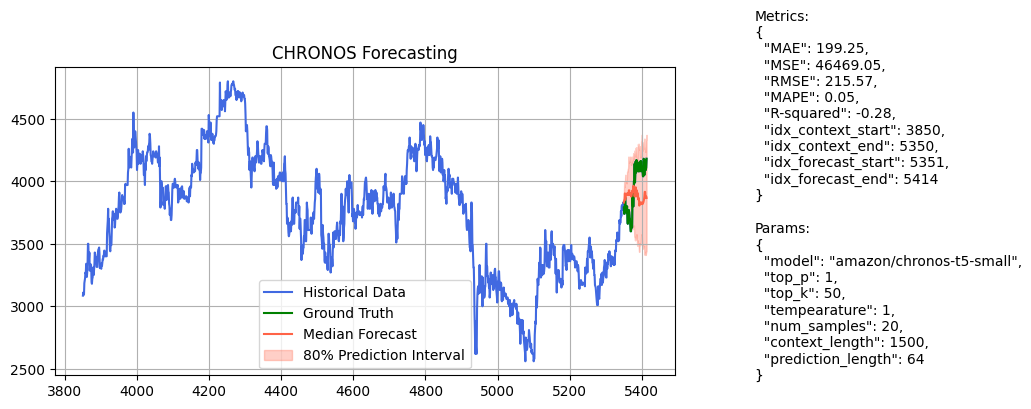

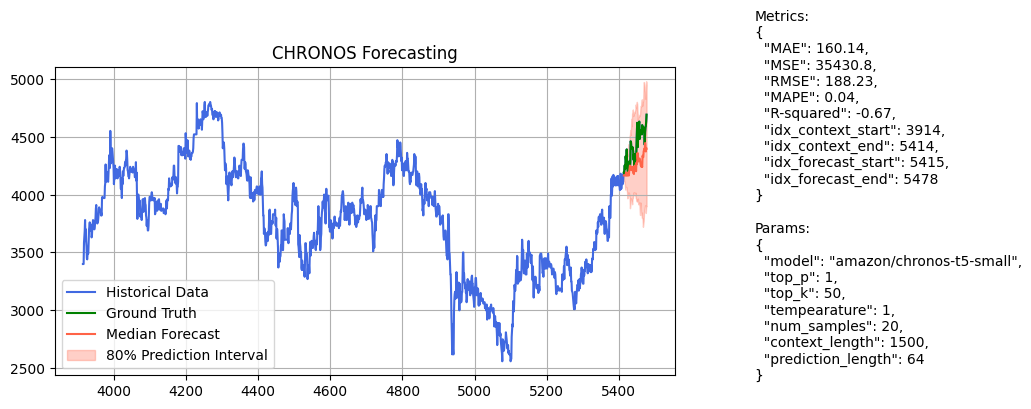

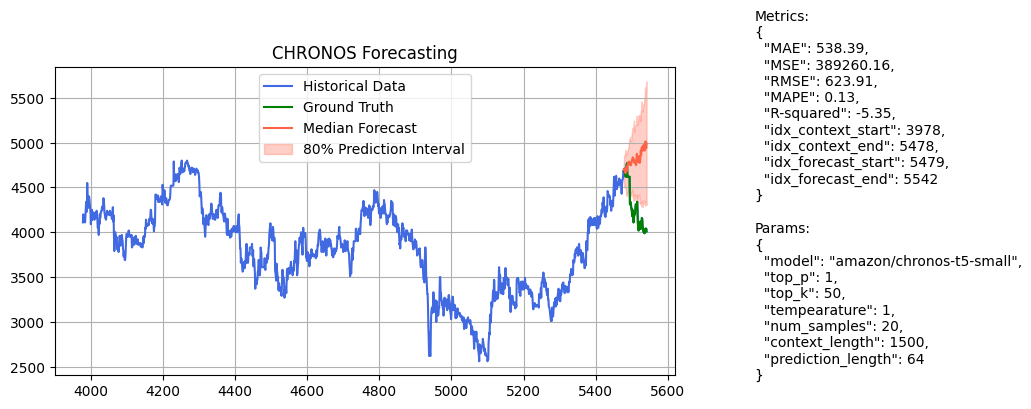

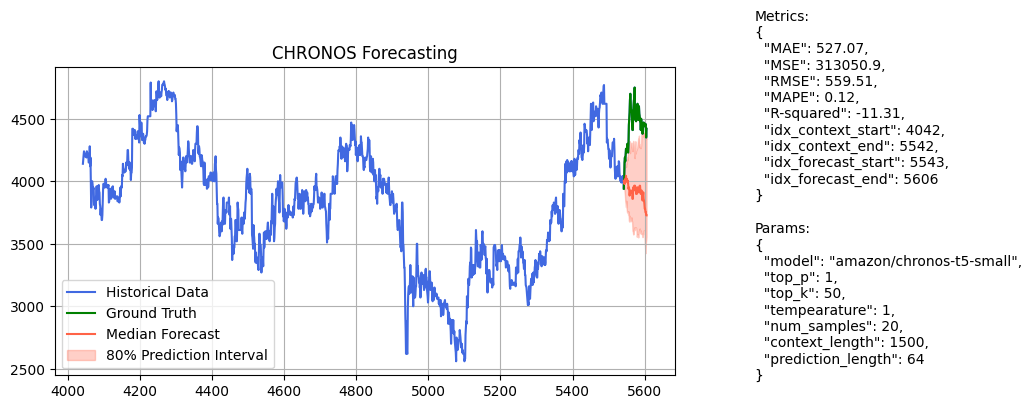

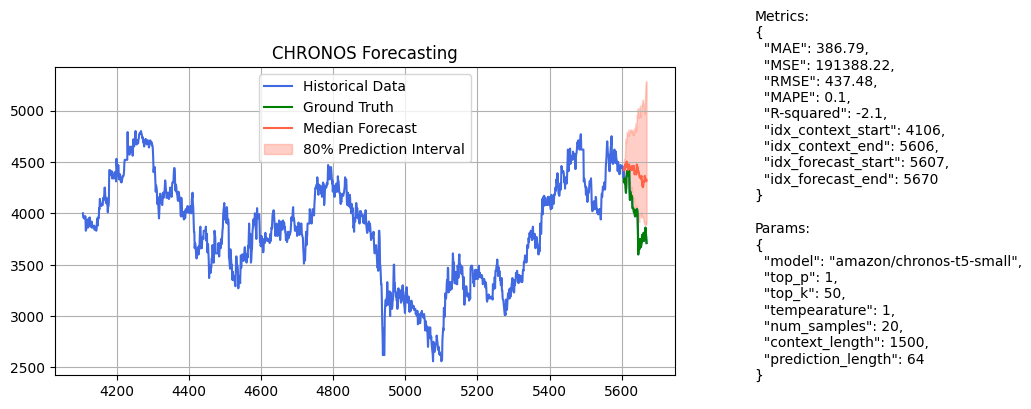

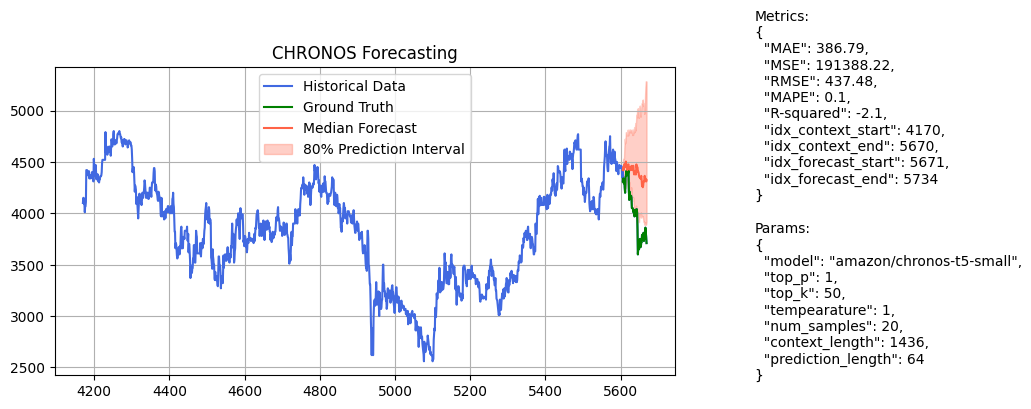

In [7]:
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/TLKM.csv')

PRED_DURATION = 365 * 1 # A multiplier of 24 as I was working with hourly dataset
FORECAST_LEN = 64 # Trying to keep this less than 64 data points for best chronos performance
PRED_START = len(df) - PRED_DURATION # The index where to split context and test data from your df
CONTEXT_LEN = 1500 # Choose this wisely from above hyperparameter tuning experiment

agg_metrics = []
pred_indices = [i for i in range(len(df), PRED_START, -FORECAST_LEN)][::-1]


og_df = df.copy()
TARGET_COLUMN = 'close'

for idx in pred_indices:
    print(f'Running with idx = {idx}')
    fc = ChronosForecaster()

    df = og_df[(idx-CONTEXT_LEN):(idx+FORECAST_LEN)].copy()

    if idx > len(og_df):
        continue

    df.dropna(inplace=True)

    context, test = fc.split_train_test_by_sample_size(df, target_column=TARGET_COLUMN, test_sample_size=FORECAST_LEN)

    forecast, metrics, median = fc.predict( model_name="amazon/chronos-t5-small", num_samples=20)

    metrics['idx_context_start'] = idx - CONTEXT_LEN
    metrics['idx_context_end'] = idx
    metrics['idx_forecast_start'] = idx + 1
    metrics['idx_forecast_end'] = idx + FORECAST_LEN

    agg_metrics.append(metrics | json.loads(fc.params))

    fc.plot_forecast(df[TARGET_COLUMN])

**Evaluasi (Matriks WQL & MASE):**

In [19]:
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from tqdm.auto import tqdm
from gluonts.dataset.common import ListDataset

from chronos import ChronosPipeline

# Load dataset
batch_size = 32
num_samples = 20
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/TLKM.csv')

# Hitung jumlah total baris
total_rows = len(df)

# Hitung 70% dari total baris
rows_to_take = int(0.7 * total_rows)

# Ambil 30% terakhir dari data
df = df.tail(rows_to_take)

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 64
freq = "D"  # Daily frequency

dataset = [
    {
        "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
        "target": df["close"].values
    }
]

# Load Chronos
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
)

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)


# Generate forecast samples
forecast_samples = []
for batch in tqdm(batcher(test_data.input, batch_size=32)):
    context = [torch.tensor(entry["target"]) for entry in batch]
    forecast_samples.append(
        pipeline.predict(
            context,
            prediction_length=prediction_length,
            num_samples=num_samples,
        ).numpy()
    )
forecast_samples = np.concatenate(forecast_samples)

# Convert forecast samples into gluonts SampleForecast objects
sample_forecasts = []
for item, ts in zip(forecast_samples, test_data.input):
    forecast_start_date = ts["start"] + len(ts["target"])
    sample_forecasts.append(
        SampleForecast(samples=item, start_date=forecast_start_date)
    )

# Evaluate
metrics_df = evaluate_forecasts(
    sample_forecasts,
    test_data=test_data,
    metrics=[
        MASE(),
        MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1)),
    ],
)

metrics_df

0it [00:00, ?it/s]

Hasil mean scaling= tensor([[0.6936, 0.6989, 0.6910, 0.6910, 0.6910, 0.6910, 0.6752, 0.6804, 0.6804,
         0.7305, 0.7464, 0.7596, 0.7543, 0.8123, 0.8018, 0.7886, 0.8097, 0.8492,
         0.8387, 0.8360, 0.8492, 0.8756, 0.8835, 0.8650, 0.9152, 0.9125, 0.8519,
         0.8545, 0.8782, 0.8703, 0.8571, 0.8782, 0.8703, 0.8703, 0.8598, 0.8650,
         0.8756, 0.9099, 0.9521, 0.9336, 0.9257, 0.9283, 0.8861, 0.8756, 0.8756,
         0.8756, 0.9046, 0.9020, 0.8730, 0.8730, 0.8730, 0.9204, 0.9152, 0.8888,
         0.8941, 0.9415, 0.9494, 0.9257, 0.9178, 0.9231, 0.9178, 0.9099, 0.8993,
         0.9152, 0.9178, 0.8941, 0.8888, 0.8598, 0.8914, 0.8545, 0.8202, 0.8519,
         0.8624, 0.8545, 0.8677, 0.8677, 0.8650, 0.8439, 0.8413, 0.8413, 0.8413,
         0.8492, 0.8466, 0.8308, 0.8387, 0.8466, 0.8360, 0.9152, 0.9178, 0.9204,
         0.9204, 0.9204, 0.9125, 0.9072, 0.8861, 0.8756, 0.8809, 0.8677, 0.8967,
         0.8967, 0.9099, 0.8914, 0.8861, 0.8941, 0.9099, 0.9072, 0.8914, 0.8861,
        

1it [00:00,  1.82it/s]


token=  tensor([[2210],
        [2209],
        [2215],
        [2225],
        [2214],
        [2207],
        [2212],
        [2220],
        [2203],
        [2215],
        [2224],
        [2218],
        [2207],
        [2205],
        [2196],
        [2218],
        [2195],
        [2233],
        [2188],
        [2223]], device='cuda:0')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[-0.3301,  0.6289, -0.3145,  ...,  0.8594,  0.5430,  0.3066]],

        [[-1.1328,  0.2129, -0.0347,  ...,  0.0098,  0.6289,  0.3223]],

        [[-0.5156,  0.5781,  0.1758,  ...,  0.9375,  0.6133,  0.3418]],

        ...,

        [[-0.0342,  0.3105,  0.5430,  ...,  0.4668, -0.2598,  0.2812]],

        [[ 0.0981,  0.5586,  0.2539,  ..., -0.5273,  1.1250,  0.3730]],

        [[-0.5234,  0.5273,  0.1689,  ...,  0.9102, -0.0820,  0.3008]]],
       device='cuda:0', dtype=torch.bfloat16)
testt1
torch.Size([20, 1])
testt2
batch_size=  20
seq_length=  1
token=  tensor([[2210],
      

1it [00:00, 275.25it/s]


,MASE[0.5],mean_weighted_sum_quantile_loss
None,14.600535,0.103768


**Menampilkan visualisasi tensorboard**

In [ ]:
%load_ext tensorboard